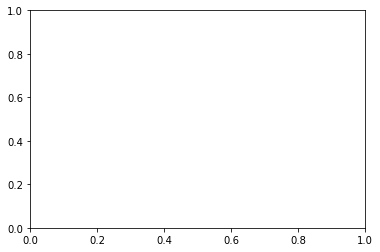

In [1]:
import os
import utils
import tensorflow as tf


In [2]:
# constents
# workspace = "../autodl-tmp"
workspace = r".\dataset"
workspace


'.\\dataset'

In [3]:
def extract_bbox(silhouette):
    """
    Extract (x_min, y_min, x_max, y_max) according to the shape of silhouette
    Note the silhouette is [H, W, channel], despite the channel is just 1
    Reference: https://stackoverflow.com/a/31402351/1471046
    """

    def convert_to_mask(silhouette, axis):
        return tf.math.count_nonzero(
            tf.squeeze(silhouette, axis=-1), axis=axis, keepdims=None, dtype=tf.bool
        )

    rows = convert_to_mask(silhouette, axis=0)
    # print(rows)
    cols = convert_to_mask(silhouette, axis=1)
    # print(cols)

    def coorindate(bin_mask) -> tf.Tensor:
        return tf.where(bin_mask)[:, -1]

    x_axis = coorindate(rows)
    x_min = x_axis[0]
    x_max = x_axis[-1]
    y_axis = coorindate(cols)
    y_min = y_axis[0]
    y_max = y_axis[-1]
    bbox = tf.concat([x_min, y_min, x_max, y_max], axis=0)
    # print(bbox)
    return tf.cast(bbox, dtype=tf.int16)


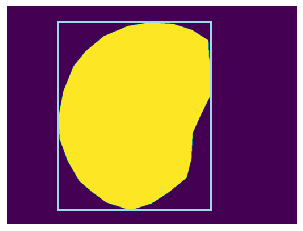

tf.Tensor([ 90  28 360 360], shape=(4,), dtype=int16)


In [4]:
# test
def test_bbox():
    file_to_test = os.path.join(
        workspace, r"ground_truth", r"ISIC_0000004_segmentation.png"
    )
    file_content = tf.io.read_file(file_to_test)
    # print(file_content.dtype)
    image = tf.io.decode_png(file_content)
    # print(image[100])
    # print(image.shape)
    box = extract_bbox(image)
    # print("box")
    utils.draw_bbox(tf.math.divide(image, 255), tf.expand_dims(box, 0))
    print(box)


test_bbox()


In [5]:
def extract_annotations():
    dir_annotation = os.path.join(workspace, "annotation")
    dir_input = os.path.join(workspace, "ground_truth")
    os.makedirs(dir_annotation, exist_ok=True)

    validation_path = os.path.join(workspace, "train", "validation.txt")
    validation_path = os.path.join(workspace, "train", "train.txt")

    for filename in os.listdir(dir_input):
        if filename.endswith(".png"):
            filepath = os.path.join(dir_input, filename)
            file_content = tf.io.read_file(filepath)
            file_id = filename.split(".")[0].replace("_segmentation", "")
            image = tf.io.decode_jpeg(file_content)
            bbox = extract_bbox(image)
            width, height, channel = image.shape
            content = f"""
<annotation>
    <filename>{file_id}.jpg</filename>
    <size>
        <width>{width}</width>
        <height>{height}</height>
        <depth>{channel}</depth>
    </size>
    <object>
        <name>lesion</name>
        <bndbox>
            <xmin>{bbox[0]}</xmin>
            <ymin>{bbox[1]}</ymin>
            <xmax>{bbox[2]}</xmax>
            <ymax>{bbox[3]}</ymax>
        </bndbox>
    </object>
</annotation>
"""
            tf.io.write_file(
                os.path.join(dir_annotation, f"{file_id}.xml"),
                contents=content,
            )


extract_annotations()
